In [2]:
import os
import joblib
import cv2
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [27]:
RAW_PATH = "../../data/raw/"
PROCESSED_PATH = "../../data/processed/"

In [52]:
def dump(value, filename):
    if value is not None and filename is not None:
        joblib.dump(value=value, filename=filename)
    else:
        raise Exception("Value or filename cannot be None".capitalize())
    
def load(filename):
    if filename is not None:
        return joblib.load(filename)
    else:
        raise Exception("Filename cannot be None".capitalize())

In [57]:
class Loader(Dataset):
    def __init__(self, image_path = None, image_size = 128, batch_size = 4, split_ratio = 0.30):
        self.image_path = image_path
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        self.image_size = image_size
        self.channels = 1
        self.images = list()
        self.masks = list()

    def unzip_folder(self):
        if os.path.exists(RAW_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_PATH, "segmented"))
        else:
            raise Exception("Raw data folder does not exist".capitalize())
    def base_transformation(self):
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def mask_transformation(self):
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            transforms.Grayscale(num_output_channels=self.channels)
        ])

    def split_dataset(self, **kwargs):
        images = kwargs["images"]
        masks = kwargs["masks"]

        return train_test_split(images, masks, test_size=self.split_ratio, random_state=42)

    def create_dataloader(self):
        images = os.listdir(os.path.join(RAW_PATH, "segmented"))[0]
        masks = os.listdir(os.path.join(RAW_PATH, "segmented"))[1]

        try:
            images = os.path.join(RAW_PATH, "segmented", images)
            masks = os.path.join(RAW_PATH, "segmented", masks)
        except Exception as e:
            print(e)

        for image in os.listdir(images):
            if image not in os.listdir(masks):
                continue
            else:
                image_path = os.path.join(images, image)
                mask_path = os.path.join(masks, image)

                self.images.append(
                    self.base_transformation()(Image.fromarray(cv2.imread(image_path))))
                self.masks.append(
                    self.mask_transformation()(Image.fromarray(cv2.imread(mask_path))))

        image_split = self.split_dataset(images=self.images, masks=self.masks)

        if os.path.exists(PROCESSED_PATH):

            dataloader = DataLoader(
                dataset=list(zip(self.images, self.masks)),
                batch_size=self.batch_size, shuffle=True)

            train_dataloader = DataLoader(
                dataset=list(zip(image_split[0], image_split[2])),
                batch_size=self.batch_size, shuffle=True)

            test_dataloader = DataLoader(
                dataset=list(zip(image_split[1], image_split[3])),
                batch_size=self.batch_size*4,
                shuffle=True,
            )

            try:
                dump(
                    value=dataloader, filename=os.path.join(PROCESSED_PATH, "dataloader.pkl"))

                dump(
                    value=train_dataloader, filename=os.path.join(PROCESSED_PATH, "train_dataloader.pkl"))

                dump(
                    value=test_dataloader, filename=os.path.join(PROCESSED_PATH, "test_dataloader.pkl"))

            except Exception as e:
                print(e)
        else:
            raise Exception("Processed data folder does not exist".capitalize())

        return dataloader

    @staticmethod
    def details_dataset():
        if os.path.exists(PROCESSED_PATH):
            
            dataloader = load(os.path.join(PROCESSED_PATH, "dataloader.pkl"))
            images, masks = next(iter(dataloader))
            print(
                "Total number of the images in the dataset is {}".format(
                    sum(image.size(0) for image, _ in dataloader)
                )
            )
            print(
                "Total number of the masks in the dataset is {}\n\n".format(
                    sum(masks.size(0) for _, masks in dataloader)
                )
            )
            print("The shape of the images is {}\nThe shape of the masks is {}".format(images.size(), masks.size()))
            
        else:
            raise Exception("Processed data folder does not exist".capitalize())

    @staticmethod
    def data_normalized(**kwargs):
        return (kwargs["data"] - kwargs["data"].min()) / (kwargs["data"].max() - kwargs["data"].min())

    @staticmethod
    def display_images():
        if os.path.exists(PROCESSED_PATH):
            dataloader = load(os.path.join(PROCESSED_PATH, "test_dataloader.pkl"))
            images, masks = next(iter(dataloader))

            plt.figure(figsize=(30, 15))

            for index, image in enumerate(images):
                image = image.permute(1, 2, 0)
                mask = masks[index].permute(1, 2, 0)

                image = Loader.data_normalized(data=image)
                mask = Loader.data_normalized(data=mask)

                plt.subplot(2 * 4, 2 * 4, 2 * index + 1)
                plt.imshow(image)
                plt.title("Image")
                plt.axis("off")

                plt.subplot(2 * 4, 2 * 4, 2 * index + 2)
                plt.imshow(mask)
                plt.title("Mask")
                plt.axis("off")

            plt.tight_layout()
            plt.show()

        else:
            raise Exception("Processed data folder does not exist".capitalize())

In [58]:
loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/brain.zip", batch_size=4, image_size=128, split_ratio=0.30)
loader.unzip_folder()
dataloader = loader.create_dataloader()

In [59]:
Loader.details_dataset()

Total number of the images in the dataset is 3064
Total number of the masks in the dataset is 3064
The shape of the images is torch.Size([4, 3, 128, 128])
The shape of the masks is torch.Size([4, 1, 128, 128])


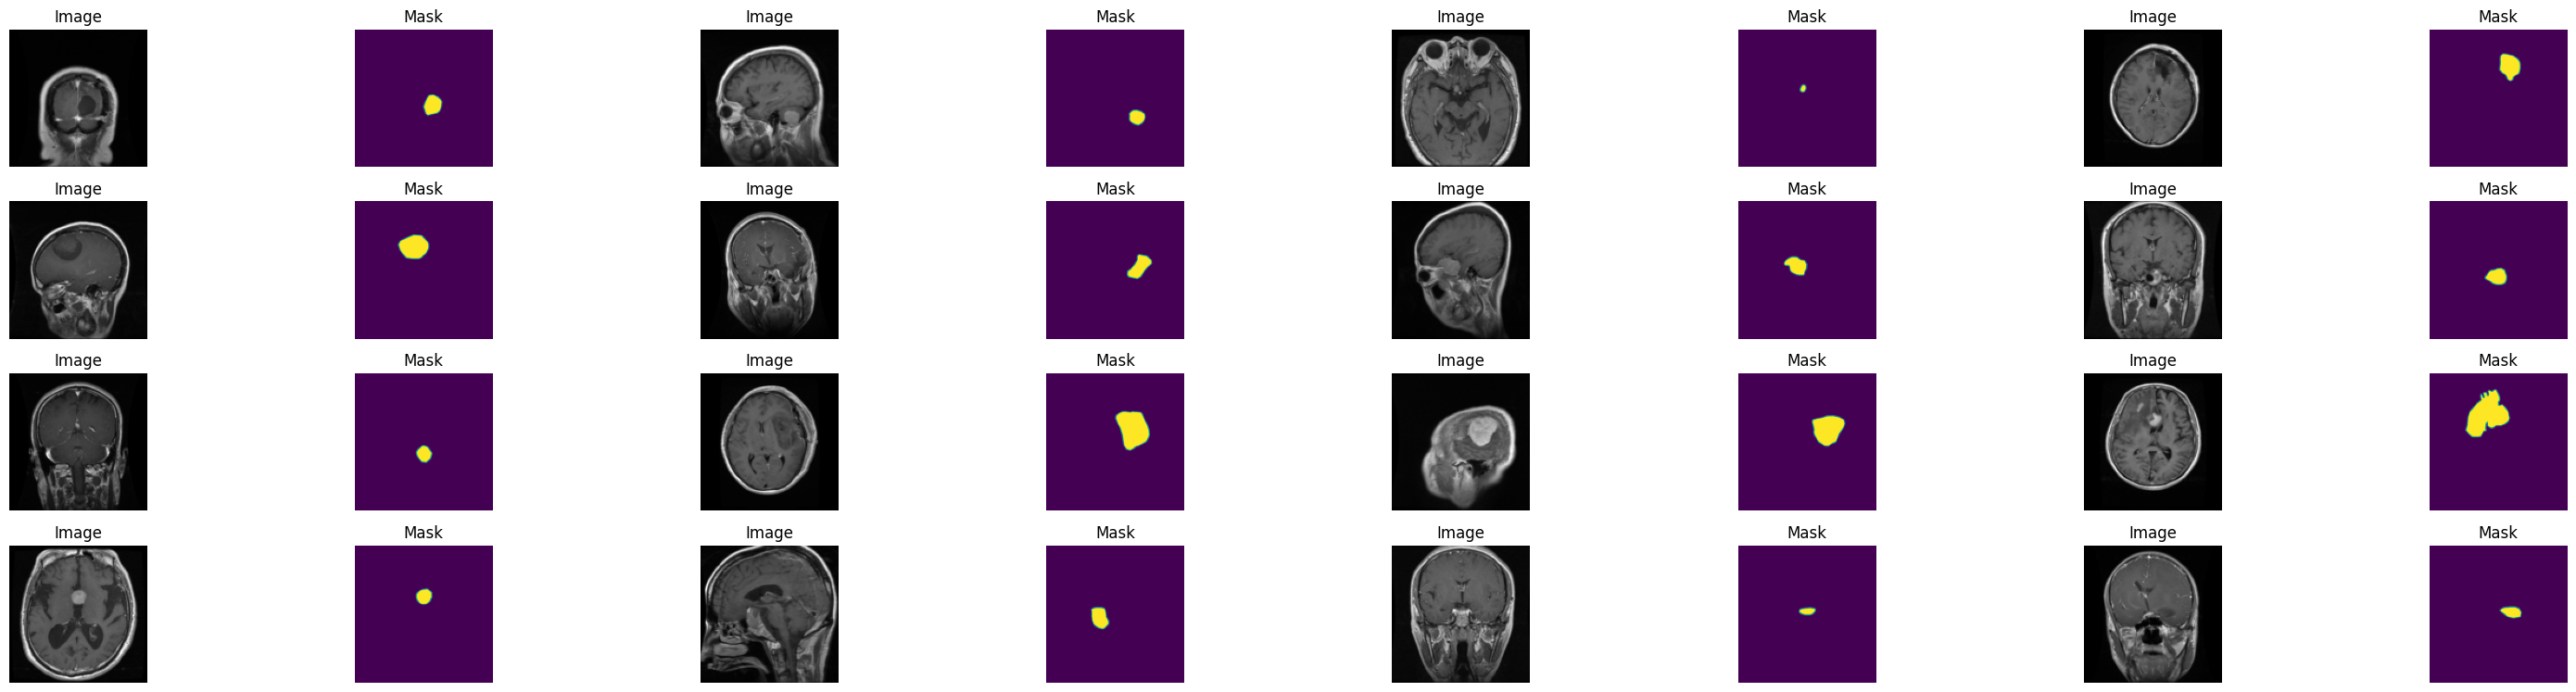

In [56]:
Loader.display_images()

In [34]:
# train_data, train_label = next(iter(train_dataloader))
# test_data, test_label = next(iter(test_dataloader))


# train_data.size(), train_label.size(), test_data.size(), test_label.size()

(torch.Size([4, 3, 128, 128]),
 torch.Size([4, 1, 128, 128]),
 torch.Size([16, 3, 128, 128]),
 torch.Size([16, 1, 128, 128]))

#### UNet

In [4]:
from collections import OrderedDict

class Encoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.encoder_block()

    def encoder_block(self):
        layers = OrderedDict()
        layers["conv1"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["relu1"] = nn.ReLU(inplace=True)
        layers["conv2"] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["batch_norm1"] = nn.BatchNorm2d(self.out_channels)
        layers["relu2"] = nn.ReLU(inplace=True)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x) if x is not None else None


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    assert encoder(torch.randn(64, 3, 128, 128)).shape == (64, 64, 128, 128)

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.decoder_block()

    def decoder_block(self):
        layers = OrderedDict()
        layers["deconv1"] = nn.ConvTranspose2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=2,
            stride=2,
        )
        return nn.Sequential(layers)

    def forward(self, x, skip_info):
        if x is not None and skip_info is not None:
            return torch.cat((self.model(x), skip_info), dim=1)
        else:
            raise ValueError("Input and skip_info cannot be None".capitalize())


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    decoder = Decoder(in_channels=64, out_channels=64)

    skip_info = encoder(torch.randn(64, 3, 256, 256))
    noise_samples = torch.randn(64, 64, 128, 128)

    assert decoder(noise_samples, skip_info).shape == (64, 128, 256, 256)

In [6]:
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_layer1 = Encoder(in_channels=3, out_channels=64)
        self.encoder_layer2 = Encoder(in_channels=64, out_channels=128)
        self.encoder_layer3 = Encoder(in_channels=128, out_channels=256)
        self.encoder_layer4 = Encoder(in_channels=256, out_channels=512)
        self.bottom_layer = Encoder(in_channels=512, out_channels=1024)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.intermediate_layer1 = Encoder(in_channels=1024, out_channels=512)
        self.intermediate_layer2 = Encoder(in_channels=512, out_channels=256)
        self.intermediate_layer3 = Encoder(in_channels=256, out_channels=128)
        self.intermediate_layer4 = Encoder(in_channels=128, out_channels=64)

        self.decoder_layer1 = Decoder(in_channels=1024, out_channels=512)
        self.decoder_layer2 = Decoder(in_channels=512, out_channels=256)
        self.decoder_layer3 = Decoder(in_channels=256, out_channels=128)
        self.decoder_layer4 = Decoder(in_channels=128, out_channels=64)

        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1), nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder path
        enc1_out = self.encoder_layer1(x)
        pooled_enc1 = self.max_pool(enc1_out)

        enc2_out = self.encoder_layer2(pooled_enc1)
        pooled_enc2 = self.max_pool(enc2_out)

        enc3_out = self.encoder_layer3(pooled_enc2)
        pooled_enc3 = self.max_pool(enc3_out)

        enc4_out = self.encoder_layer4(pooled_enc3)
        pooled_enc4 = self.max_pool(enc4_out)

        bottom_out = self.bottom_layer(pooled_enc4)

        # Decoder path
        dec1_input = self.decoder_layer1(bottom_out, enc4_out)
        dec1_out = self.intermediate_layer1(dec1_input)

        dec2_input = self.decoder_layer2(dec1_out, enc3_out)
        dec2_out = self.intermediate_layer2(dec2_input)

        dec3_input = self.decoder_layer3(dec2_out, enc2_out)
        dec3_out = self.intermediate_layer3(dec3_input)

        dec4_input = self.decoder_layer4(dec3_out, enc1_out)
        dec4_out = self.intermediate_layer4(dec4_input)

        # Final output
        final_output = self.final_layer(dec4_out)

        return final_output